### **Install & Import Dependencies**

In [7]:
!pip install split-folders tensorflow matplotlib seaborn


In [8]:
import os
import splitfolders
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

### **Download and Prepare Dataset**

In [9]:
!wget -O "dataset.zip" "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"
!unzip -q dataset.zip

--2025-07-08 08:19:25--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2025-07-08 08:19:26--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.65.151, 3.5.71.10, 3.5.70.206, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|3.5.65.151|:443... conne

### **Split dataset into train, val, test**

In [10]:
splitfolders.ratio('/content/Plant_leave_diseases_dataset_with_augmentation',
                   output="dataset", seed=1337, ratio=(.8, .1, .1))

Copying files: 61486 files [00:11, 5564.43 files/s]


### **Load Dataset**

In [11]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [12]:
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/val"
test_dir = "/content/dataset/test"

In [13]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 49179 files belonging to 39 classes.
Found 6139 files belonging to 39 classes.
Found 6168 files belonging to 39 classes.


In [14]:
class_names = train_dataset.class_names
num_classes = len(class_names)

### **Optimize Data Loading**

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### **Data Augmentation**

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

### **Load EfficientNet Model**

In [17]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB4(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model.trainable = False

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### **Model Architecture**

In [18]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

### **Compile Model**

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### **Callbacks**

In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy")

### **Initial Training**

In [21]:
initial_epochs = 6
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=initial_epochs,
                    callbacks=[early_stop, checkpoint])

Epoch 1/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 219s 126ms/step - accuracy: 0.6550 - loss: 1.3497 - val_accuracy: 0.8816 - val_loss: 0.4299
Epoch 2/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 187s 122ms/step - accuracy: 0.8572 - loss: 0.4923 - val_accuracy: 0.9029 - val_loss: 0.3334
Epoch 3/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 205s 123ms/step - accuracy: 0.8795 - loss: 0.4027 - val_accuracy: 0.9083 - val_loss: 0.3029
Epoch 4/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 196s 119ms/step - accuracy: 0.8863 - loss: 0.3623 - val_accuracy: 0.9179 - val_loss: 0.2716
Epoch 5/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 182s 118ms/step - accuracy: 0.8908 - loss: 0.3469 - val_accuracy: 0.9225 - val_loss: 0.2432
Epoch 6/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 199s 116ms/step - accuracy: 0.8969 - loss: 0.3258 - val_accuracy: 0.9199 - val_loss: 0.2463


### **Fine-tuning**

In [22]:
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [23]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

In [24]:
history_fine = model.fit(train_dataset,
                         validation_data=val_dataset,
                         initial_epoch=history.epoch[-1],
                         epochs=total_epochs,
                         callbacks=[early_stop, checkpoint])

Epoch 6/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 572s 323ms/step - accuracy: 0.5773 - loss: 1.7106 - val_accuracy: 0.8702 - val_loss: 0.4199
Epoch 7/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 498s 320ms/step - accuracy: 0.8553 - loss: 0.4638 - val_accuracy: 0.9199 - val_loss: 0.2430
Epoch 8/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 504s 322ms/step - accuracy: 0.9128 - loss: 0.2761 - val_accuracy: 0.9464 - val_loss: 0.1632
Epoch 9/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 502s 322ms/step - accuracy: 0.9424 - loss: 0.1859 - val_accuracy: 0.9594 - val_loss: 0.1185
Epoch 10/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 504s 323ms/step - accuracy: 0.9527 - loss: 0.1448 - val_accuracy: 0.9673 - val_loss: 0.0943
Epoch 11/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 501s 322ms/step - accuracy: 0.9642 - loss: 0.1130 - val_accuracy: 0.9739 - val_loss: 0.0759
Epoch 12/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 494s 321ms/step - accuracy: 0.9711 - loss: 0.0878 - val_accuracy: 0.9806 - val_loss: 0.0622
Epoch 13/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 493s 320ms/step 

### **Plot Training Graphs**

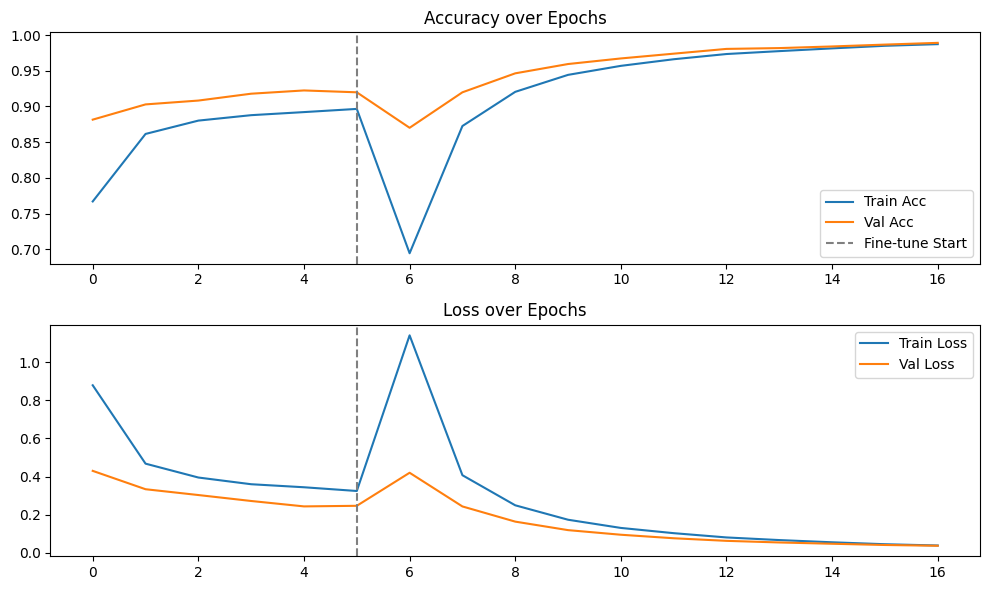

In [25]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.axvline(x=initial_epochs-1, color='gray', linestyle='--', label='Fine-tune Start')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.axvline(x=initial_epochs-1, color='gray', linestyle='--')
plt.title('Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

### **Evaluate on Test Set**

In [26]:
loss, accuracy = model.evaluate(test_dataset)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

193/193 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.9911 - loss: 0.0288
Test Accuracy: 98.82%


### **Confusion Matrix and Classification Report**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

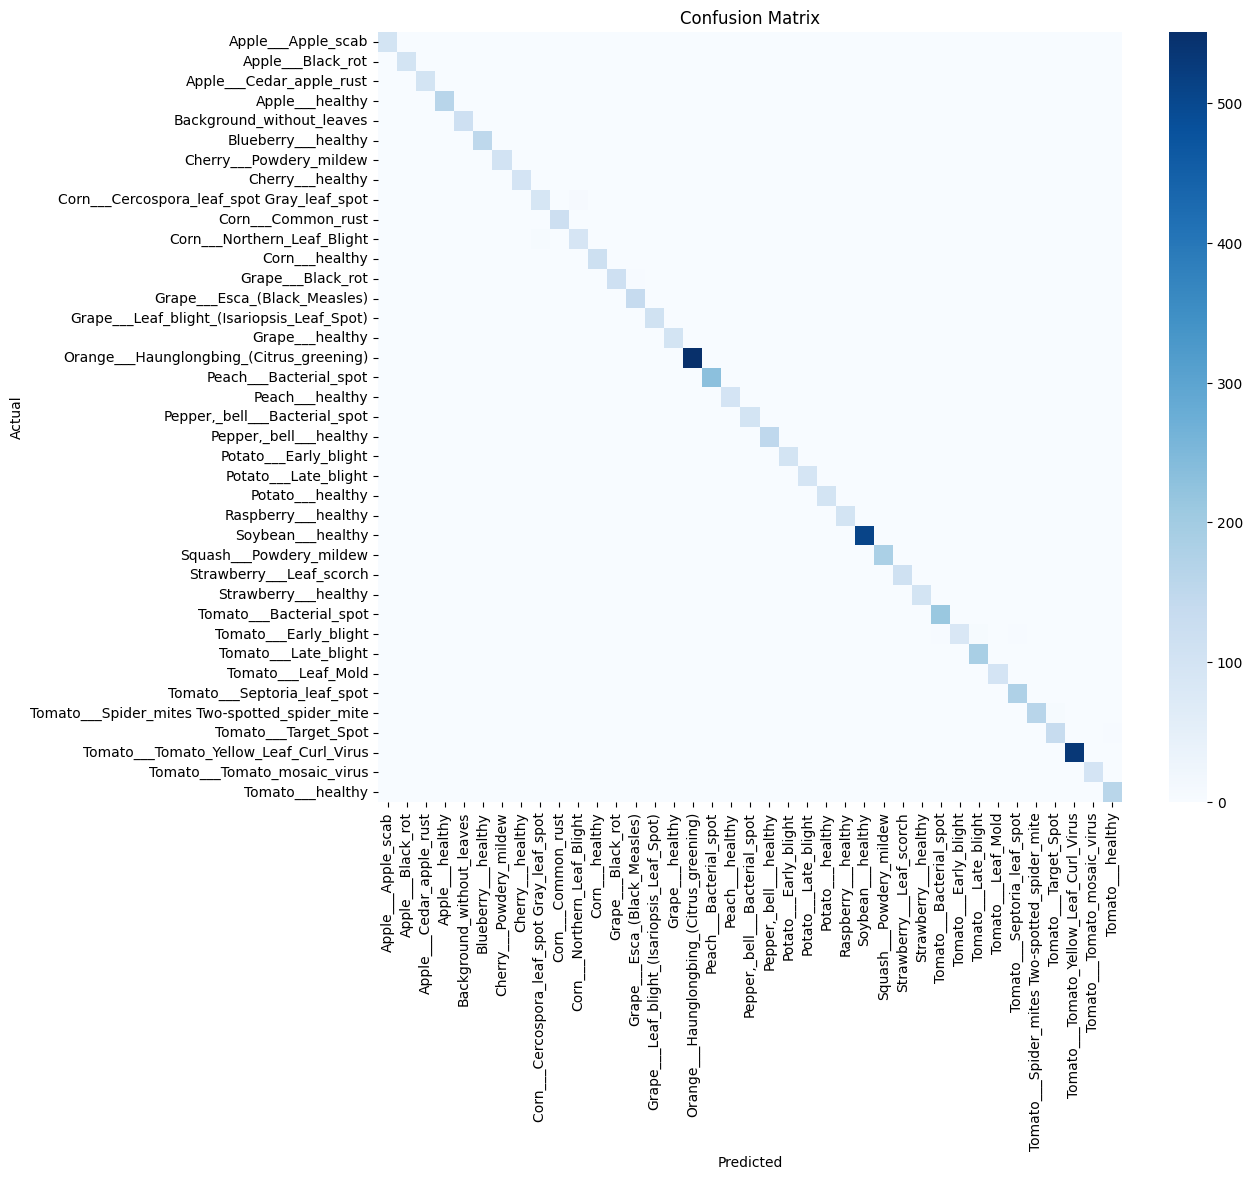

In [28]:
# Gather all test data
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_labels = tf.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


### **Save Model**

In [30]:
model.save("/content/drive/MyDrive/efficientnet_plant_disease_model.keras")
